<a href="https://colab.research.google.com/github/sgoldyaev/DLS-GAN/blob/master/sgoldyaev_HW_NST_pix2pix_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

# Результаты

---


* **GAN (MNIST)** - научится создавать простую архитектуру - ГОТОВО
* **Info GAN (MNIST)** - научится управлять контентом и стилями изображения - НЕ ГОТОВО
* **Neural Style Transfer** - научится объединять контент со стилем - ГОТОВО
* **Multi Style Transfer** - использование двух стилей - ГОТОВО

![image.png](https://lh5.googleusercontent.com/EFRlJw__4pswptnvw4c7CyMDiosq3BpVU6nuJKFlp0ZcQr7UHvfQoS8PvWaQUguTmXbiF5azUjvPU058-s32=w1365-h888-rw)

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

In [0]:
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import itertools
import copy
import requests

from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from torchvision import datasets, transforms
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 42

In [0]:
class BasicBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=3, stride=1, dilation=1):
    super(BasicBlock, self).__init__()

    self.convolution = nn.Sequential(
        nn.Conv2d(in_features, 64, kernel_size=1, stride=stride, dilation=dilation),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=1),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),

        nn.Conv2d(64, out_features, kernel_size=1, stride=stride, dilation=dilation),
        nn.InstanceNorm2d(out_features),
      )
    
    self.shortcut = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=1),
        nn.InstanceNorm2d(out_features),
      )

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    cnv = self.convolution(x)
    cut = self.shortcut(x)
    return (cnv+x)

class ResidualBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=3, stride=1, dilation=1, padding=1):
    super(ResidualBlock, self).__init__()

    self.convolution = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding),
        nn.InstanceNorm2d(out_features),
      )
    
    self.shortcut = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=kernel_size*2-1, stride=stride, dilation=dilation, padding=padding*2),
        nn.InstanceNorm2d(out_features),
      )

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    cnv = self.convolution(x)
    cut = self.shortcut(x)
    #return (cnv + x)
    return (cnv + cut)

class DownsamplingBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=3, stride=1, dilation=1, padding=0):
    super(DownsamplingBlock, self).__init__()

    self.convolution = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
      )

  def forward(self, x):
    cnv = self.convolution(x)
    return (cnv)

class UpsamplingBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=3, stride=1, dilation=1, padding=0, output_padding=0):
    super(UpsamplingBlock, self).__init__()

    self.deconv = nn.ConvTranspose2d(in_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding, output_padding=output_padding)
    self.output = nn.Sequential(
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
      )

  def forward(self, x, output_size):
    cnv = self.deconv(x, output_size=output_size)
    cnv = self.output(cnv)
    return (cnv)

### U-model
class GeneratorU(nn.Module):
  def __init__(self, in_features):
    super(GeneratorU, self).__init__()

    self.enc1 = DownsamplingBlock(in_features, 16)
    self.enc2 = DownsamplingBlock(16, 32)
    self.enc3 = DownsamplingBlock(32, 64)
    
    self.bottleneck = nn.Sequential(
        BasicBlock(64, 64),
    )

    self.dec3 = UpsamplingBlock(64, 32)
    self.dec2 = UpsamplingBlock(32, 16)
    self.dec1 = UpsamplingBlock(16, in_features)

  def forward(self, x):
    e1 = self.enc1(x)
    e2 = self.enc2(e1)
    e3 = self.enc3(e2)
    b = self.bottleneck(e3)
    d3 = self.dec3(b, output_size=e2.size())
    d2 = self.dec2(d3, output_size=e1.size())
    d1 = self.dec1(d2, output_size=x.size())
    return d1

class DiscriminatorU(nn.Module):
  def __init__(self, in_features, out_features):
    super(DiscriminatorU, self).__init__()

    self.layers = nn.Sequential(
        ResidualBlock(in_features, 16, kernel_size=1, stride=1, padding=0),
        ResidualBlock(16, 32, kernel_size=1, stride=1, padding=0),
        ResidualBlock(32, 64, kernel_size=1, stride=1, padding=0),

        BasicBlock(64, 64),

        ResidualBlock(64, 32, kernel_size=1, stride=1, padding=0),
        ResidualBlock(32, 16, kernel_size=1, stride=1, padding=0),
        ResidualBlock(16, 8, kernel_size=1, stride=1, padding=0),
    )

    self.out = nn.Sequential(
        nn.Linear(8 * 1 * 28 * 28, 4),
        nn.Linear(4, out_features),
        nn.Sigmoid()        
    )

  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)

    return self.out(x)

### Linear model
class GeneratorL(nn.Module):
  def __init__(self, out_size):
    super(GeneratorL, self).__init__()

    self.out_size = out_size
    self.n_elements = np.array(out_size).prod()
    self.layers = nn.Sequential(
        nn.Linear(self.n_elements, 256),
        nn.ReLU(),

        nn.Linear(256, 512),
        nn.ReLU(),

        nn.Linear(512, 1024),
        nn.ReLU(),

        nn.Linear(1024, self.n_elements),
        nn.Tanh(),
    )

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    y = self.layers(x)
    #y = torch.tanh(y)
    y = y.view(-1, self.out_size[0], self.out_size[1], self.out_size[2])
    return y

class DiscriminatorL(nn.Module):
  def __init__(self, out_size, out_features):
    super(DiscriminatorL, self).__init__()

    self.out_size = out_size
    self.n_elements = np.array(out_size).prod()
    self.layers = nn.Sequential(
        nn.Linear(self.n_elements, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(256, self.n_elements-3),
        nn.ReLU(),
        nn.Dropout(0.3),
    )

    self.out = nn.Sequential(
        nn.Linear(self.n_elements-3, out_features),
        nn.Sigmoid()        
    )

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    y = self.layers(x)
    y = self.out(y)
    return y

class Generator(nn.Module):
  def __init__(self, in_features):
    super(Generator, self).__init__()

    self.enc1 = DownsamplingBlock(in_features, 16, stride=1, dilation=1)
    self.enc2 = DownsamplingBlock(16, 32, stride=1, dilation=1)
    self.enc3 = DownsamplingBlock(32, 64, stride=1, dilation=1)
    
    self.bottleneck = nn.Sequential(
        BasicBlock(64, 64),
    )

    self.dec3 = UpsamplingBlock(2*64, 32, stride=1, dilation=1)
    self.dec2 = UpsamplingBlock(2*32, 16, stride=1, dilation=1)
    self.dec1 = UpsamplingBlock(2*16, in_features, stride=1, dilation=1)

  def forward(self, x):
    e1 = self.enc1(x)
    e2 = self.enc2(e1)
    e3 = self.enc3(e2)

    b = self.bottleneck(e3)

    d3 = self.dec3(torch.cat([b, e3], dim=1), output_size=e2.size())
    d2 = self.dec2(torch.cat([d3, e2], dim=1), output_size=e1.size())
    d1 = self.dec1(torch.cat([d2, e1], dim=1), output_size=x.size())
    return d1


class Discriminator(nn.Module):
  def __init__(self, in_features, out_features):
    super(Discriminator, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_features, 16, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(16),
        nn.ReLU(inplace=True),

        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(32),
        nn.ReLU(inplace=True),

        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),
    )

    self.out = nn.Sequential(
        nn.Linear(64 * 4 * 4, out_features),
        nn.Sigmoid()        
    )

  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)

    return self.out(x)

In [19]:
out_size = (1, 28, 28)
g = GeneratorL(out_size).to(device)
d = DiscriminatorL(out_size, 1).to(device)
summary(g, out_size), summary(d, out_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 512]         131,584
              ReLU-4                  [-1, 512]               0
            Linear-5                 [-1, 1024]         525,312
              ReLU-6                 [-1, 1024]               0
            Linear-7                  [-1, 784]         803,600
              Tanh-8                  [-1, 784]               0
Total params: 1,661,456
Trainable params: 1,661,456
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 6.34
Estimated Total Size (MB): 6.38
----------------------------------------------------------------
--------------------------------------

(None, None)

In [20]:
traintransform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,)),
     ])

imagedataset = torchvision.datasets.MNIST('mnist', train=True, transform=traintransform, download=True)
predsdataset = torchvision.datasets.MNIST('mnist', train=False, transform=traintransform, download=True)

(trainidx, validx), batch_size = train_test_split(range(len(imagedataset)), test_size=0.25, random_state=SEED, stratify=imagedataset.targets), 10*1024

trainsubset = torch.utils.data.Subset(imagedataset, trainidx)
valsubset = torch.utils.data.Subset(imagedataset, validx)
predsubset = torch.utils.data.Subset(imagedataset, range(0, 40))

trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
valloader = torch.utils.data.DataLoader(valsubset, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
predsloader = torch.utils.data.DataLoader(predsubset, batch_size=10, num_workers=8, pin_memory=True, shuffle=False)

print (len(imagedataset), len(trainsubset), len(valsubset), len(predsdataset), np.bincount(imagedataset.targets[trainsubset.indices]), np.bincount(imagedataset.targets[valsubset.indices]))

60000 45000 15000 10000 [4442 5056 4469 4598 4381 4066 4439 4699 4388 4462] [1481 1686 1489 1533 1461 1355 1479 1566 1463 1487]


In [37]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
image = images[0]

m1 = GeneratorL((1, 28, 28))
m2 = Generator(1)

y1 = m1(images[:1].view(-1, 28*28))
y2 = m2(images[:1])

figure = plt.figure()
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(image.numpy().squeeze(), cmap='gray_r');

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(y1[0].detach().numpy().squeeze(), cmap='gray_r');

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(y2[0].detach().numpy().squeeze(), cmap='gray_r');

NameError: ignored

GAN (MNIST)
---
![alt text](https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-3-319-78452-6_5/MediaObjects/456829_1_En_5_Fig1_HTML.gif)

Честно написаная собственными руками GAN для генерации картинки. Обучение на MNIST. 

ЦЕЛИ:
* Учимся писать архитектуру простого GAN.

In [0]:
ganidx, batch_size = (imagedataset.targets == 3).nonzero().squeeze(), 1024

gansubset = torch.utils.data.Subset(imagedataset, ganidx)
ganloader = torch.utils.data.DataLoader(gansubset, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

size = (1, 28, 28)
lr = 2e-4

discriminator = DiscriminatorL(size, 1).to(device)
generator = GeneratorL(size).to(device)

criterion_D = torch.nn.BCELoss()
criterion_G = torch.nn.BCELoss()

optimizer_D = torch.optim.AdamW(discriminator.parameters(), lr=lr, weight_decay=1e-3, amsgrad=True)
optimizer_G = torch.optim.AdamW(generator.parameters(), lr=lr, weight_decay=1e-3, amsgrad=True)

losses_D = []
losses_G = []

outputs_G, outputs_D = [], []

for epoch in range(0, 20):
  epoch_losses_D, epoch_losses_G = [], []
  for inputs, labels in ganloader:

    ## Discriminator
    for step_D in range(50):
      discriminator.train()
      discriminator.zero_grad()

      real_input, real_output = inputs.to(device), torch.ones(labels.shape[0], 1).to(device) # labels.to(device)
      output_D = discriminator(real_input)
      loss_D_real = criterion_D(output_D, real_output)

      fake_input, fake_output = torch.randn(inputs.size()).to(device), torch.zeros(labels.shape[0], 1).to(device)
      fake_input, fake_output = Variable(fake_input), Variable(fake_output)
      output_D = discriminator(fake_input)
      loss_D_fake = criterion_D(output_D, fake_output)

      loss_D = (loss_D_real + loss_D_fake)

      loss_D.backward()
      optimizer_D.step()

      epoch_losses_D.append(loss_D.data.item())

    ## Generator
    for step_G in range(1):
      #discriminator.train()
      #discriminator.zero_grad()
      generator.train()
      generator.zero_grad()

      mock_input, mock_output = torch.randn(inputs.size()).to(device), torch.ones(labels.shape[0], 1).to(device)
      mock_input, mock_output = Variable(mock_input), Variable(mock_output)
      output_G = generator(mock_input)
      output_D = discriminator(output_G)

      loss_G = criterion_D(output_D, mock_output)

      loss_G.backward()
      optimizer_G.step()

      epoch_losses_G.append(loss_G.data.item())
      outputs_G.append(output_G.to('cpu').detach().numpy().squeeze())
      outputs_D.append(torch.argmax(output_D, dim=1).to('cpu').detach().numpy().squeeze())

  losses_D.append(np.mean(epoch_losses_D))
  losses_G.append(np.mean(epoch_losses_G))

  print ('epoch {}. loss D:{:4f}, G:{:4f}'.format(epoch, losses_D[-1], losses_G[-1]))

epoch 0. loss D:0.045660, G:0.647427
epoch 1. loss D:0.000002, G:0.041951
epoch 2. loss D:0.000002, G:0.001598
epoch 3. loss D:0.000001, G:0.000117
epoch 4. loss D:0.000001, G:0.000030
epoch 5. loss D:0.000001, G:0.000012
epoch 6. loss D:0.000001, G:0.000008
epoch 7. loss D:0.000001, G:0.000009
epoch 8. loss D:0.000001, G:0.000004
epoch 9. loss D:0.000001, G:0.000005
epoch 10. loss D:0.000001, G:0.000006
epoch 11. loss D:0.000000, G:0.000004
epoch 12. loss D:0.000000, G:0.000006
epoch 13. loss D:0.000000, G:0.000004
epoch 14. loss D:0.000000, G:0.000006
epoch 15. loss D:0.000000, G:0.000009
epoch 16. loss D:0.000000, G:0.000005
epoch 17. loss D:0.000000, G:0.000006
epoch 18. loss D:0.000000, G:0.000005
epoch 19. loss D:0.000000, G:0.000002


In [23]:
len(np.concatenate(outputs_G))

122620

Смотрим какие картинки были сгенерированы в процессе обучения.

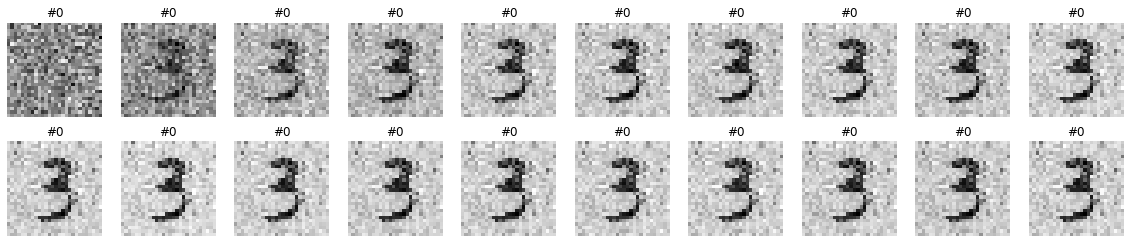

In [24]:
step = int(len(np.concatenate(outputs_G))/20)
subsetimages = np.concatenate(outputs_G)[0::step]
subsetpreds = np.concatenate(outputs_D)[0::step]

fig, ax = plt.subplots(nrows=int(len(subsetimages)/10), ncols=10, figsize=(20, 4), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
  fig_x.axis('off')
  fig_x.imshow(subsetimages[i], cmap='gray_r')
  fig_x.set_title('#{}'.format(subsetpreds[i]))

Здесь генерим картинку по входному шуму

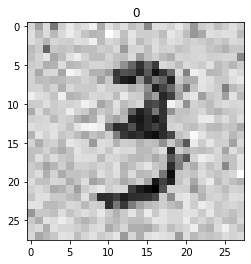

In [25]:
with torch.no_grad():
  generator.eval()
  x = Variable(torch.randn((1, 1, 28, 28)).to(device))
  y = generator(x)
  z = discriminator(y)
  p = torch.argmax(z)
  y = y.to('cpu')
  p = p.to('cpu')
  img = y[0].detach().numpy().squeeze()
  pred = p.detach().numpy().squeeze()
  plt.imshow(img, cmap='gray_r');
  plt.title(pred)

InfoGAN (MNIST with latent codes)
---
* https://arxiv.org/pdf/1606.03657.pdf

![](https://aiden.nibali.org/img/infogan_vs_gan_archs.svg)
* 
 $\log p(c|\hat{c},\sigma^{2})=\frac{1}{2\sigma^{2}}(c-\hat{c})^{2}+\frac{N}{2}\log\sigma^{2}+\frac{N}{2}\log(2\pi)$

ЦЕЛИ:
* Учимся управлять генерацией (содержимым и стилем) картинки. 
* Вводим понятие Latent codes
* Discrete Latent Codes: 1 класс цифры от 0 до 9.
* Continius Latent Codes: два класса от -1 до 1. Наклон и Толщина начертания
* В коде много заимствований.

In [0]:
class GeneratorInfo(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        nn.ConvTranspose2d(74, 1024, 1, 1, bias=False),
        nn.BatchNorm2d(1024),
        nn.ReLU(),

        nn.ConvTranspose2d(1024, 128, 7, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False),
    )

  def forward(self, x):
    x = self.layers(x)
    y = torch.sigmoid(x)

    return y

class DiscriminatorInfo(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.1),

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1),

        nn.Conv2d(128, 1024, kernel_size=7, bias=False),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.1),
    )

  def forward(self, x):
    x = self.layers(x)
    return x

class HeadD(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv = nn.Conv2d(1024, 1, 1)

  def forward(self, x):
    y = torch.sigmoid(self.conv(x))
    return y

class HeadQ(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.layers = nn.Sequential(
        nn.Conv2d(1024, 128, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1, inplace=True)
    )
    
    self.conv_disc = nn.Conv2d(128, 10, 1)
    self.conv_mu = nn.Conv2d(128, 2, 1)
    self.conv_var = nn.Conv2d(128, 2, 1)

  def forward(self, x):
    x = self.layers(x)

    logits = self.conv_disc(x).squeeze()

    mu = self.conv_mu(x).squeeze()
    var = torch.exp(self.conv_var(x).squeeze())

    return logits, mu, var

class NormalNLLLoss:
  """
  Calculate the negative log likelihood
  of normal distribution.
  This needs to be minimised.
  Treating Q(cj | x) as a factored Gaussian.
  """
  def __call__(self, x, mu, var):
    logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
    nll = -(logli.sum(1).mean())

    return nll

def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
  """
  Sample random noise vector for training.
  INPUT
  --------
  n_dis_c : Number of discrete latent code.
  dis_c_dim : Dimension of discrete latent code.
  n_con_c : Number of continuous latent code.
  n_z : Dimension of iicompressible noise.
  batch_size : Batch Size
  device : GPU/CPU
  """

  z = torch.randn(batch_size, n_z, 1, 1, device=device)

  idx = np.zeros((n_dis_c, batch_size))
  if(n_dis_c != 0):
    dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
    for i in range(n_dis_c):
      idx[i] = np.random.randint(dis_c_dim, size=batch_size)
      dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

      dis_c = dis_c.view(batch_size, -1, 1, 1)

  if(n_con_c != 0):
    # Random uniform between -1 and 1.
    con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

  noise = z
  if(n_dis_c != 0):
    noise = torch.cat((z, dis_c), dim=1)
  if(n_con_c != 0):
    noise = torch.cat((noise, con_c), dim=1)

  return noise, idx

In [0]:
del generator, discriminator, gansubset, ganloader

#torch.cuda.empty_cache()

NameError: ignored

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialise the network.
generator = GeneratorInfo().to(device)
generator.apply(weights_init)
print(generator)

discriminator = DiscriminatorInfo().to(device)
discriminator.apply(weights_init)
print(discriminator)

head_D = HeadD().to(device)
head_D.apply(weights_init)
print(head_D)

head_Q = HeadQ().to(device)
head_Q.apply(weights_init)
print(head_Q)

# Loss for discrimination between real and fake images.
criterion_D = nn.BCELoss()
# Loss for discrete latent code.
criterion_Q_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterion_Q_con = NormalNLLLoss()

lr = 2e-4

# Adam optimiser is used.
optimizator_D = torch.optim.Adam([{'params': discriminator.parameters()}, {'params': head_D.parameters()}], lr=lr)
optimizator_G = torch.optim.Adam([{'params': generator.parameters()}, {'params': head_Q.parameters()}], lr=lr)

RuntimeError: ignored

In [0]:
ganidx, batch_size = (imagedataset.targets)[:1000].nonzero().squeeze(), 512

gansubset = torch.utils.data.Subset(imagedataset, ganidx)
ganloader = torch.utils.data.DataLoader(gansubset, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)

In [0]:
#params['num_z'] = 62
#params['num_dis_c'] = 1
#params['dis_c_dim'] = 10
#params['num_con_c'] = 2

n_noize = 62
n_classes = 10
n_features = 2
n_epoches = 20

# Fixed Noise
z = torch.randn(100, n_noize, 1, 1)
fixed_noise = z

idx = np.arange(n_classes).repeat(10)
dis_c = torch.zeros(100, 1, n_classes)
for i in range(1):
  dis_c[torch.arange(0, 100), i, idx] = 1.0

dis_c = dis_c.view(100, -1, 1, 1)

fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

con_c = torch.rand(100, 2, 1, 1) * 2 - 1
fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...\n")

start_time = time.time()
iters = 0

for epoch in range(n_epoches):
  epoch_start_time = time.time()
  i = 0

  for inputs, labels in ganloader:
    b_size = inputs.size(0)
    real_input, real_output = inputs.to(device), torch.ones(labels.shape[0], 1).to(device) # labels.to(device)

    optimizator_D.zero_grad()

    # Real data
    output_D = discriminator(real_input)
    probs_real = head_D(output_D).view(-1)
    loss_real = criterion_D(probs_real, real_output)

    # Fake data
    noise, idx = noise_sample(n_classes, 1, 2, n_noize, b_size, device)
    fake_input, fake_output = noise, torch.zeros(labels.shape[0], 1).to(device)
    fake_input, fake_output = Variable(fake_input), Variable(fake_output)

    # Fake data treated as fake
    output_G = generator(noise)
    output_D = discriminator(output_G)
    probs_fake = head_D(output_D).view(-1)
    loss_fake = criterion_D(probs_fake, fake_output)

    D_loss = loss_real + loss_fake
    D_loss.backward();
    optimizator_D.step()
    optimizator_G.zero_grad()

    # Fake data treated as real
    output_D = discriminator(output_G)
    probs_fake = head_D(output_D).view(-1)
    gen_loss = criterion_D(probs_fake, real_output)

    q_logits, q_mu, q_var = head_Q(output_D)
    target = torch.LongTensor(idx).to(device)

    # Calculating loss for discrete latent code.
    dis_loss = 0
    for j in range(n_features):
      dis_loss += criterion_Q_dis(q_logits[:, j*10 : j*10 + 10], target[j])

    # Calculating loss for continuous latent code.
    con_loss = criterion_Q_con(noise[:, n_noize + 1*n_classes : ].view(-1, n_features), q_mu, q_var)*0.1

    # Net loss for generator.
    G_loss = gen_loss + dis_loss + con_loss
    # Calculate gradients.
    G_loss.backward()
    # Update parameters.
    optimizator_G.step()

    # Check progress of training.
    if i != 0 and i%100 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch+1, n_epoches, i, len(dataloader), D_loss.item(), G_loss.item()))

    # Save the losses for plotting.
    G_losses.append(G_loss.item().cpu().numpy())
    D_losses.append(D_loss.item().cpu().numpy())

    iters += 1

  epoch_time = time.time() - epoch_start_time
  print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
  # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
  with torch.no_grad():
    gen_data = generator(fixed_noise).detach().cpu()
  img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
  if((epoch+1) == 1 or (epoch+1) == n_epoches/2):
    with torch.no_grad():
      gen_data = generator(fixed_noise).detach().cpu()
  plt.figure(figsize=(10, 10))
  plt.axis("off")
  plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
  plt.savefig("Epoch_{}".format(epoch+1))
  plt.close('all')
'''
    # Save network weights.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'netG' : netG.state_dict(),
            'discriminator' : discriminator.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'optimD' : optimD.state_dict(),
            'optimG' : optimG.state_dict(),
            'params' : params
            }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))
'''

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = generator(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_{}".format(n_epoches))

'''
# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/model_final_{}'.format(params['dataset']))
'''

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss Curve {}".format(params['dataset']))

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('infoGAN_{}.gif'.format(params['dataset']), dpi=80, writer='imagemagick')
plt.show()

Starting Training Loop...



RuntimeError: ignored

## NST (Нейронный перенос стиля с Pytorch)

In [0]:
def http_image_loader(image_url):
  response = requests.get(image_url)
  image = Image.open(BytesIO(response.content))
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

def imshow(tensor, title=None):
  image = tensor.cpu().clone()   
  image = image.squeeze(0)      # функция для отрисовки изображения
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) 

def gram_matrix(input):
  a, b, c, d = input.size()  # a=batch size(=1)
  # b=number of feature maps
  # (c,d)=dimensions of a f. map (N=c*d)
  features = input.view(a * b, c * d)  # resize feature maps
  G = torch.mm(features, features.t())  # compute the gram product
  # we 'normalize' the values of the gram matrix
  # by dividing by the number of element in each feature maps.
  return G.div(a * b * c * d)

class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    # we 'detach' the target content from the tree used
    # to dynamically compute the gradient: this is a stated value,
    # not a variable. Otherwise the forward method of the criterion
    # will throw an error.
    self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
    self.loss = F.mse_loss(self.target, self.target )#to initialize with something

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()
    self.loss = F.mse_loss(self.target, self.target)# to initialize with something

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # .view the mean and std to make them [C x 1 x 1] so that they can
    # directly work with image Tensor of shape [B x C x H x W].
    # B is batch size. C is number of channels. H is height and W is width.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # normalize img
    return (img - self.mean) / self.std

def get_input_optimizer(input_img):
  # this line to show that input is a parameter that requires a gradient
  #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
  optimizer = torch.optim.LBFGS([input_img.requires_grad_()]) 
  return optimizer

In [57]:
!wget https://ru.artsviewer.com/images/P/picasso/1931-10.jpg
!wget https://ru.artsviewer.com/images/P/picasso/1910-8.jpg
!wget http://artsviewer.com/images/V/vinci/1504-3.jpg
!wget http://artsviewer.com/images/V/vinci/1503-2.jpg
!ls /content

--2020-06-15 22:54:46--  https://ru.artsviewer.com/images/P/picasso/1931-10.jpg
Resolving ru.artsviewer.com (ru.artsviewer.com)... 67.20.112.63
Connecting to ru.artsviewer.com (ru.artsviewer.com)|67.20.112.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418397 (409K) [image/jpeg]
Saving to: ‘1931-10.jpg’

1931-10.jpg         100%[===================>] 408.59K   686KB/s    in 0.6s    

2020-06-15 22:54:48 (686 KB/s) - ‘1931-10.jpg’ saved [418397/418397]

--2020-06-15 22:54:49--  https://ru.artsviewer.com/images/P/picasso/1910-8.jpg
Resolving ru.artsviewer.com (ru.artsviewer.com)... 67.20.112.63
Connecting to ru.artsviewer.com (ru.artsviewer.com)|67.20.112.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481148 (470K) [image/jpeg]
Saving to: ‘1910-8.jpg.1’

1910-8.jpg.1        100%[===================>] 469.87K   746KB/s    in 0.6s    

2020-06-15 22:54:50 (746 KB/s) - ‘1910-8.jpg.1’ saved [481148/481148]

--2020-06-15 22:54:52--  

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

style_img_url = '/content/1503-2.jpg'
content_img_url = '/content/1504-3.jpg'

style_img = image_loader(style_img_url)# as well as here
content_img = image_loader(content_img_url)#измените путь на тот который у вас.

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


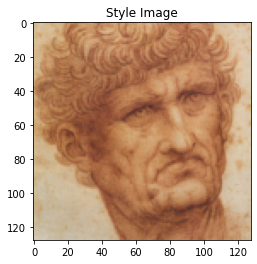

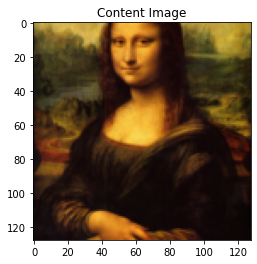

In [71]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 
# отрисовка

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
  
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                              style_img, content_img,
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):
  cnn = copy.deepcopy(cnn)
  
  # normalization module
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  
  # just in order to have an iterable access to or list of content/style losses
  content_losses = []
  style_losses = []
  
  # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
  # to put in modules that are supposed to be activated sequentially
  model = nn.Sequential(normalization)
  
  i = 0  # increment every time we see a conv
  for layer in cnn.children():
      if isinstance(layer, nn.Conv2d):
          i += 1
          name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
          name = 'relu_{}'.format(i)
          # The in-place version doesn't play very nicely with the ContentLoss
          # and StyleLoss we insert below. So we replace with out-of-place
          # ones here.
          layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
          name = 'pool_{}'.format(i)
      elif isinstance(layer, nn.BatchNorm2d):
          name = 'bn_{}'.format(i)
      else:
          raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
  
      model.add_module(name, layer)
  
      if name in content_layers:
          # add content loss:
          target = model(content_img).detach()
          content_loss = ContentLoss(target)
          model.add_module("content_loss_{}".format(i), content_loss)
          content_losses.append(content_loss)
  
      if name in style_layers:
          # add style loss:
          target_feature = model(style_img).detach()
          style_loss = StyleLoss(target_feature)
          model.add_module("style_loss_{}".format(i), style_loss)
          style_losses.append(style_loss)
  
  # now we trim off the layers after the last content and style losses
  for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break
  
  model = model[:(i + 1)]
  
  return model, style_losses, content_losses


def run_style_transfer(cnn, normalization_mean, normalization_std, 
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
  """Run the style transfer."""
  print('Building the style transfer model..')
  model, style_losses, content_losses = get_style_model_and_losses(cnn,
      normalization_mean, normalization_std, style_img, content_img)
  optimizer = get_input_optimizer(input_img)

  print('Optimizing..')
  run = [0]
  while run[0] <= num_steps:

      def closure():
          # correct the values 
          # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
          input_img.data.clamp_(0, 1)

          optimizer.zero_grad()

          model(input_img)

          style_score = 0
          content_score = 0

          for sl in style_losses:
              style_score += sl.loss
          for cl in content_losses:
              content_score += cl.loss
          
          #взвешивание ошибки
          style_score *= style_weight
          content_score *= content_weight

          loss = style_score + content_score
          loss.backward()

          run[0] += 1
          if run[0] % 50 == 0:
              print('Run {}: Style Loss : {:4f} Content Loss: {:4f}'.format(
                  run, style_score.item(), content_score.item()))

          return style_score + content_score

      optimizer.step(closure)

  # a last correction...
  input_img.data.clamp_(0, 1)

  return input_img

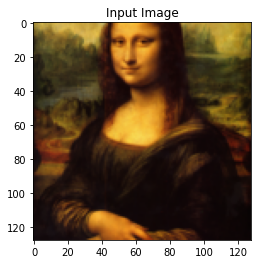

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Run [50]: Style Loss : 18.327948 Content Loss: 9.894283
Run [100]: Style Loss : 5.212566 Content Loss: 8.045381
Run [150]: Style Loss : 2.090224 Content Loss: 6.962014
Run [200]: Style Loss : 1.519387 Content Loss: 6.460406
Run [250]: Style Loss : 1.358091 Content Loss: 6.254208
Run [300]: Style Loss : 1.272326 Content Loss: 6.166247
Run [350]: Style Loss : 1.228169 Content Loss: 6.118202
Run [400]: Style Loss : 1.201363 Content Loss: 6.086954
Run [450]: Style Loss : 1.182140 Content Loss: 6.063801
Run [500]: Style Loss : 1.164515 Content Loss: 6.049963


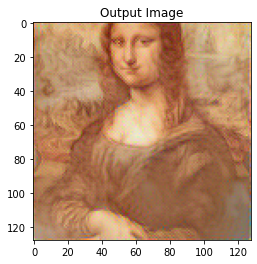

In [76]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## Multi Style Transfer

In [0]:
def load_image(img_path, max_size=400, shape=None):
  ''' Load in and transform an image, making sure the image
      is <= 400 pixels in the x-y dims.'''
  
  image = Image.open(img_path).convert('RGB')
  
  # large images will slow down processing
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  
  if shape is not None:
    size = shape
      
  in_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

  # discard the transparent, alpha channel (that's the :3) and add the batch dimension
  image = in_transform(image)[:3,:,:].unsqueeze(0)
  
  return image

# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
  """ Display a tensor as an image. """
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

def get_features(image, model, layers=None):
  """ Run an image forward through a model and get the features for 
      a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
  """
  
  ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
  ## Need the layers for the content and style representations of an image
  if layers is None:
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content representation
              '28': 'conv5_1'}
      
  features = {}
  x = image
  # model._modules is a dictionary holding each module in the model
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
          
  return features

def gram_matrix(tensor):
  """ Calculate the Gram Matrix of a given tensor 
      Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
  """
  
  # get the batch_size, depth, height, and width of the Tensor
  _, d, h, w = tensor.size()
  
  # reshape so we're multiplying the features for each channel
  tensor = tensor.view(d, h * w)
  
  # calculate the gram matrix
  gram = torch.mm(tensor, tensor.t())
  
  return gram

In [0]:
# load in content and style image
content = load_image('/content/1504-3.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/1503-2.jpg', shape=content.shape[-2:]).to(device)
style2 = load_image('/content/1931-10.jpg', shape=content.shape[-2:]).to(device)

Text(0.5, 1.0, 'Style 2 Image')

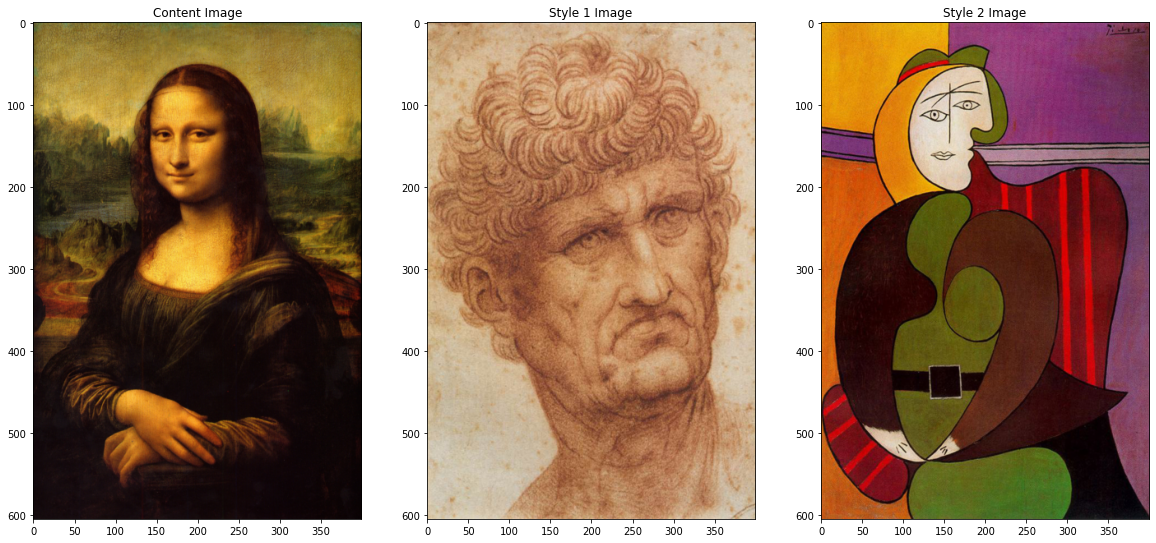

In [59]:
# display the images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax1.set_title('Content Image')

ax2.imshow(im_convert(style))
ax2.set_title('Style 1 Image')

ax3.imshow(im_convert(style2))
ax3.set_title('Style 2 Image')

In [0]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg = models.vgg19(pretrained=True).features.to(device).eval()

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
  param.requires_grad_(False)

# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 0.6,
                 'conv2_1': 0.7,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

style2_weights = {'conv1_1': 0.5,
                 'conv2_1': 0.4,
                 'conv3_1': 0.5,
                 'conv4_1': 0.5,
                 'conv5_1': 0.4}

content_weight = 1  # alpha
# style_weight = 1e10  # beta
# style_weight = 1e6  # beta
style_weight = 1e7  # beta
style2_weight = 1e7  # beta


In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style2_features = get_features(style2, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
style2_grams = {layer: gram_matrix(style2_features[layer]) for layer in style2_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [72]:
# iteration hyperparameters
optimizer = torch.optim.Adam([target], lr=3e-3)
steps = 2000  # decide how many iterations to update your image (5000)
show_every = int(steps / 5)

for ii in range(1, steps+1):
  
  # get the features from your target image
  target_features = get_features(target, vgg)
  
  # the content loss
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  
  # the style loss
  # initialize the style loss to 0
  style_loss = 0
  style2_loss = 0

  # then add to it for each layer's gram matrix loss
  for layer in style_weights:
    # get the "target" style representation for the layer
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    # get the "style" style representation
    style_gram = style_grams[layer]
    style2_gram = style2_grams[layer]
    # the style loss for one layer, weighted appropriately
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2) 
    layer_style2_loss = style2_weights[layer] * torch.mean((target_gram - style2_gram)**2)
    # add to the style loss
    style_loss += layer_style_loss / (d * h * w)
    style2_loss += layer_style2_loss / (d * h * w)
      
  # calculate the *total* loss
  total_loss = content_weight * content_loss + style_weight * style_loss + style2_weight * style2_loss
  
  # update your target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    # progress = int(ii/show_every)
    # plt.subplot(1, 5, progress)
    # plt.imshow(im_convert(target))
    # #plt.set_title('Image {}/{}'.format(ii, steps))
    # plt.axis('off')
    # plt.show()

Total loss:  1239545344.0
Total loss:  1140908160.0
Total loss:  1113122304.0
Total loss:  1100399488.0
Total loss:  1093290368.0


(-0.5, 399.5, 604.5, -0.5)

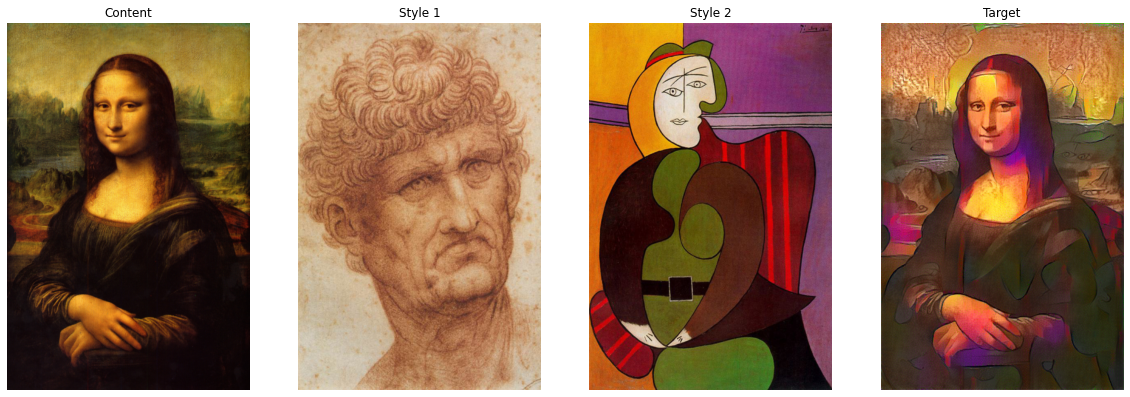

In [73]:
# display content and final, target image
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_title('Content')
ax1.axis('off')

ax2.imshow(im_convert(style))
ax2.set_title('Style 1')
ax2.axis('off')

ax3.imshow(im_convert(style2))
ax3.set_title('Style 2')
ax3.axis('off')

ax4.imshow(im_convert(target))
ax4.set_title('Target')
ax4.axis('off')